<a href="https://colab.research.google.com/github/Wejdan999/task5/blob/main/Copy_of_Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,GRU,SimpleRNN
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import sklearn
from sklearn.impute import SimpleImputer

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [2]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 60.3MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [4]:
tra=pd.read_csv('/content/Traffic Data.csv')

In [5]:
tra.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [6]:
tra.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [51]:
tra_sam=tra.head(1000)

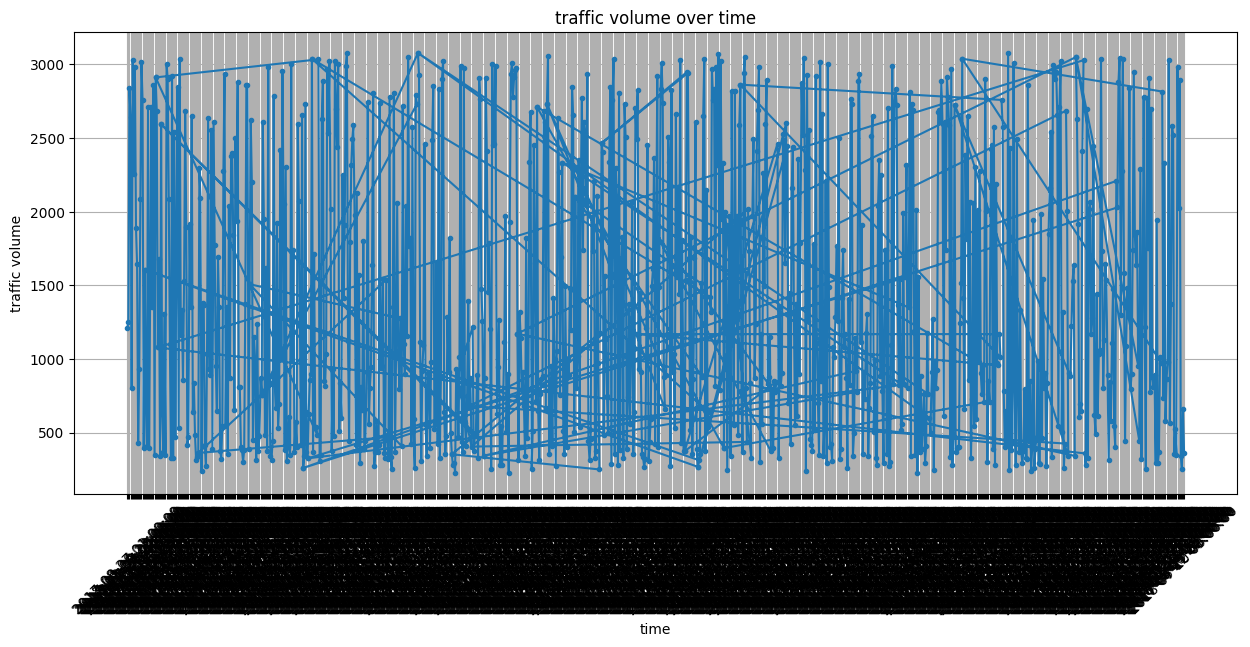

In [52]:
plt.figure(figsize=(15,6))
plt.plot(tra_sam['date_time'],tra_sam['traffic_volume'], marker=".")
plt.title('traffic volume over time')
plt.xlabel('time')
plt.ylabel('traffic volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [22]:
#chiking null values
tra_sam.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [21]:
#handling null values using bfill and ffill to keep value correct
tra_sam['traffic_volume']= tra_sam['traffic_volume'].bfill().ffill()

<Axes: ylabel='traffic_volume'>

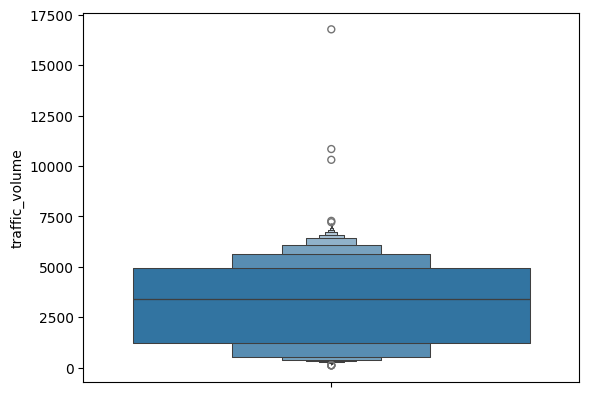

In [11]:
#before removing outleir
sns.boxenplot(tra['traffic_volume'])

In [12]:
#handling outlier
Q1=tra['traffic_volume'].quantile(0.25)
Q3=tra['traffic_volume'].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-0.5*IQR
upper_bound=Q3-0.5*IQR
tra=tra[(tra['traffic_volume']>= lower_bound)&(tra['traffic_volume']<=upper_bound)]

<Axes: ylabel='traffic_volume'>

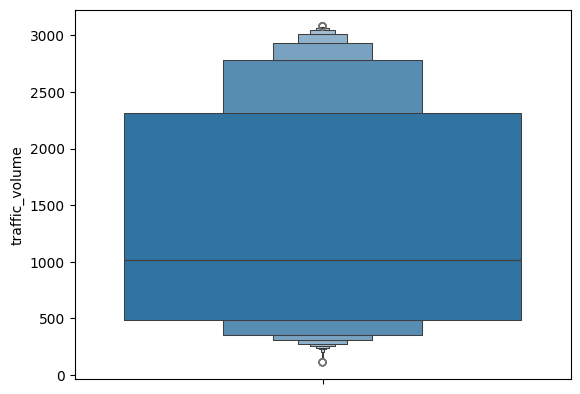

In [13]:
#after removing outlier
sns.boxenplot(tra['traffic_volume'])

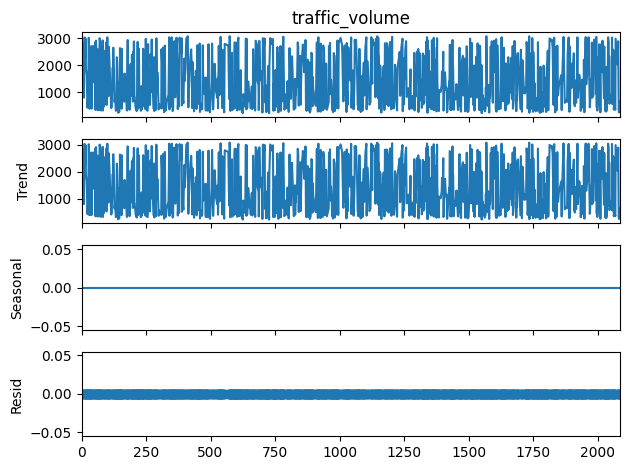

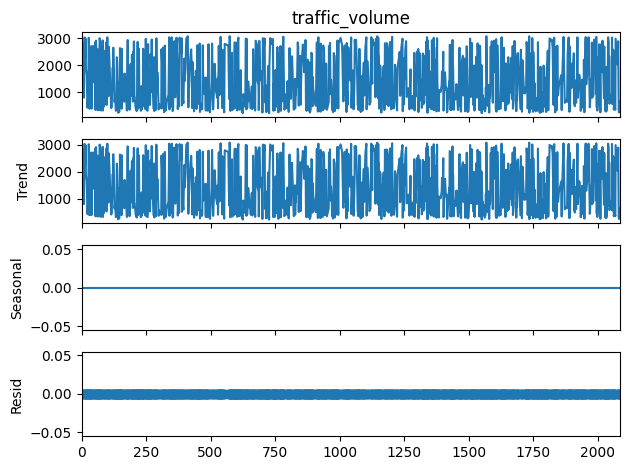

In [53]:
result = seasonal_decompose(tra_sam['traffic_volume'],model ='additive', period=1)
result.plot()

it is a seasonal trend

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [ ]:
#Shift Method
#tra=tra['prev_traffic_volume']=tra['traffic_volume'].shift(1)


In [91]:
#tra_sam['traffic_volume']=tra_sam['traffic_volume'].diff()

<ipython-input-91-4687888e7fc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tra_sam['traffic_volume']=tra_sam['traffic_volume'].diff()


In [24]:

tra['Day of the week']=tra.date_time.dayofweek
tra['Month']=tra.date_time.month
tra['Day of the year']=tra.date_time.dayofyear

AttributeError: 'Series' object has no attribute 'dayofweek'

In [25]:
tra_sam['date_time']=pd.to_datetime(tra['date_time'])
tra_sam=tra_sam.set_index('date_time')


In [26]:
#sorting data by the index by the year
tra_sam.sort_index()


,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-19 23:00:00,1913.0,267.160,0.0,0.0,1,Clear,sky is clear
2016-11-25 10:00:00,3076.0,274.620,0.0,0.0,90,Mist,mist
2016-11-26 02:00:00,474.0,271.650,0.0,0.0,1,Mist,mist
2016-11-27 05:00:00,469.0,271.280,0.0,0.0,75,Mist,mist
2016-11-28 01:00:00,304.0,280.020,0.0,0.0,90,Mist,mist
...,...,...,...,...,...,...,...
NaT,336.0,263.792,0.0,0.0,0,Clear,Sky is Clear
NaT,336.0,289.690,0.0,0.0,90,Rain,light rain
NaT,253.0,301.210,0.0,0.0,5,Clear,sky is clear


In [27]:
#resampling
tra_sam['traffic_volume'].resample('Q').mean()

,traffic_volume
date_time,
2016-12-31,1400.440000
2017-03-31,1141.900000
2017-06-30,1475.500000
2017-09-30,1279.181818
2017-12-31,1530.777778
2018-03-31,1464.409091
2018-06-30,1353.000000
2018-09-30,1361.656250


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [54]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []

    data_array = dataset.values
    for i in range(len(data_array) - time_step - 1):
        a = data_array[i:(i + time_step), 0]
        X.append(a)
        Y.append(data_array[i + time_step, 0])
    return np.array(X), np.array(Y)
time_step=30
X, Y = create_dataset(tra_sam[['traffic_volume']], time_step)

In [55]:
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [56]:
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)


mimx = MinMaxScaler()
X_train_scaled = mimx.fit_transform(X_train_2d)
X_test_scaled = mimx.transform(X_test_2d)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [80]:

Y_test_scaled= mimx.fit_transform(Y_test.reshape(-1, 1))


## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [63]:
#RNN MODEL
model = Sequential()

model.add(SimpleRNN(units=70, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=70, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=70))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_16 (SimpleRNN)            │ (None, 30, 70)              │           5,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 30, 70)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_17 (SimpleRNN)            │ (None, 30, 70)              │           9,870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 70)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_18 (SimpleRNN)            │ (None, 70)                  │           9,870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              71 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,851 (97.07 KB)

 Trainable params: 24,851 (97.07 KB)

 Non-trainable params: 0 (0.00 B)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [58]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 2923994.5000 - val_loss: 2891806.0000
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2653169.0000 - val_loss: 2884041.5000
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2763249.7500 - val_loss: 2880153.7500
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2786901.7500 - val_loss: 2877192.2500
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2691295.2500 - val_loss: 2874395.5000
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2765561.5000 - val_loss: 2871584.2500
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2742824.7500 - val_loss: 2868814.5000
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2744816.7500 - val_loss: 2866068.7500
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2648769.5000 - val_loss: 2863332.0000
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2627360.2500 - val_loss: 2860649.0000
Epoch 11/100
13/13 

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [64]:
predictions = model.predict(X_test_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [89]:
print(math.sqrt(mean_squared_error(Y_test_scaled,predictions)))

0.7697061640048187


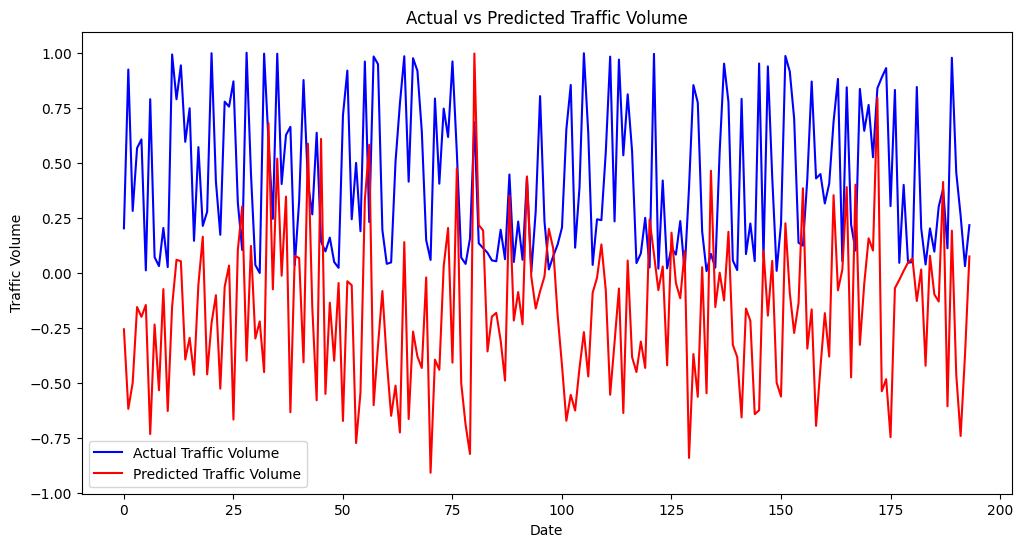

In [90]:
plt.figure(figsize=(12,6))
plt.plot(Y_test_scaled, label='Actual Traffic Volume', color='blue')
plt.plot(predictions, label='Predicted Traffic Volume', color='red')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [47]:
#GRU MODEL
model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    GRU(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 2874052.0000 - val_loss: 2442885.5000
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2771840.0000 - val_loss: 2430813.2500
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2733020.7500 - val_loss: 2418337.7500
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2533036.2500 - val_loss: 2404971.0000
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2909196.2500 - val_loss: 2389852.0000
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2797322.0000 - val_loss: 2373111.5000
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2621945.5000 - val_loss: 2354804.5000
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2767771.7500 - val_loss: 2334177.7500
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2429105.0000 - val_loss: 2311887.5000
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2570030.5000 - val_loss: 2287437.5000
Epoch 11/100
12/12 

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [84]:
predicted_GRU= model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [87]:


print(math.sqrt(mean_squared_error(Y_test_scaled,predicted_GRU)))

0.7866581079925331


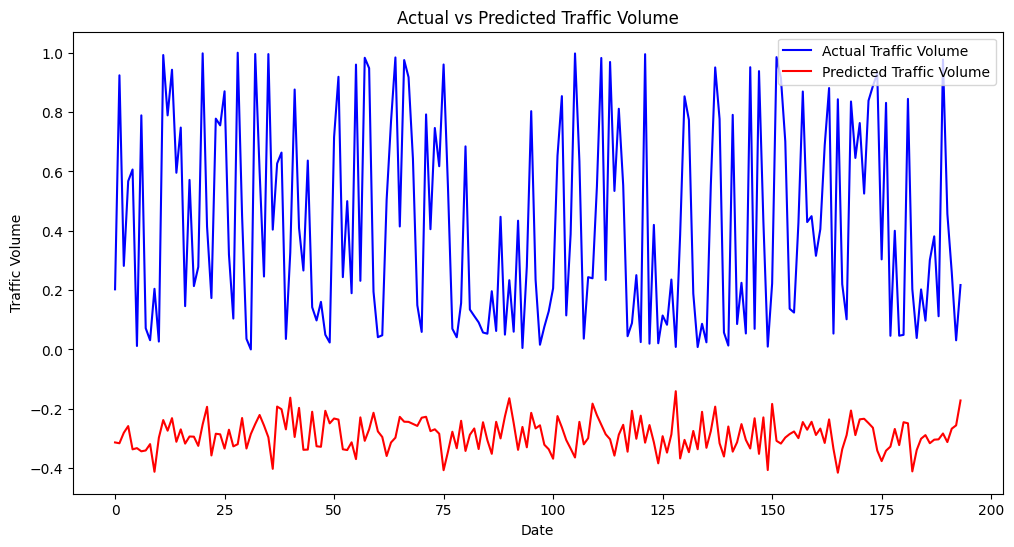

In [88]:
plt.figure(figsize=(12,6))
plt.plot(Y_test_scaled, label='Actual Traffic Volume', color='blue')
plt.plot(predicted_GRU, label='Predicted Traffic Volume', color='red')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

I uesd for handling missing values ffill,bfill method it help keeping the value correct. I try to do the featuer but it makes error to the model and I don't want waste time so I put it as comment. In the model I try hard to improv it by incress the eboch and the unit ufortunately this the best reasult I have it will be more better if I have much time